Cell 1: Imports & Setup

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


DATASET_ROOT = r"G:\Thesis-Fall-25-26--G-606\data"

IMAGES_DIR = os.path.join(DATASET_ROOT, "Images")
LABELS_FILE = os.path.join(DATASET_ROOT, "Labels.csv")

IMG_SIZE = (64, 64)  # 64x64 is optimal for KNN
SEED = 42

# Global dictionary to store results for comparison
results = {}

print("Libraries loaded and configuration set.")

Libraries loaded and configuration set.


Cell 2: Data Loading Function

In [7]:
def load_data(csv_path, img_dir, size):
    df = pd.read_csv(csv_path)
    data = []
    labels = []

    print("Loading images...")
    for idx, row in df.iterrows():
        img_name = row['Image Name']
        label_text = row['Label']
        img_path = os.path.join(img_dir, img_name)

        if os.path.exists(img_path):
            try:
                # Load in Grayscale
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue

                # Resize
                img = cv2.resize(img, size)

                # Flatten (convert 2D image to 1D array)
                data.append(img.flatten())

                # Convert Label: GON+ = 1, GON- = 0
                labels.append(1 if label_text == 'GON+' else 0)
            except:
                pass

    return np.array(data), np.array(labels)

# Load the initial data
X_raw, y = load_data(LABELS_FILE, IMAGES_DIR, IMG_SIZE)
print(f"Data Loaded: {X_raw.shape[0]} images.")

Loading images...
Data Loaded: 747 images.


Cell 3: Stage 1 - Raw Data (No Cleaning/Scaling)

In [8]:
print("--- STAGE 1: RAW DATA (Baseline) ---")

# Split Raw Data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=SEED, stratify=y)

# Initialize KNN (Raw)
knn_raw = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_raw.fit(X_train_raw, y_train)

# Predict
pred_raw = knn_raw.predict(X_test_raw)
acc_raw = accuracy_score(y_test, pred_raw)

results['1. Raw Data'] = acc_raw
print(f"Stage 1 Accuracy: {acc_raw*100:.2f}%")
print(classification_report(y_test, pred_raw, target_names=['Healthy', 'Glaucoma']))

--- STAGE 1: RAW DATA (Baseline) ---
Stage 1 Accuracy: 84.67%
              precision    recall  f1-score   support

     Healthy       0.81      0.55      0.66        40
    Glaucoma       0.85      0.95      0.90       110

    accuracy                           0.85       150
   macro avg       0.83      0.75      0.78       150
weighted avg       0.84      0.85      0.84       150



Cell 4: Stage 2 - Cleaned Data (Scaled/Normalized)

In [9]:
print("--- STAGE 2: CLEANED/SCALED DATA ---")

# Scaler
scaler = StandardScaler()

# Fit on training data ONLY to prevent data leakage
X_train_clean = scaler.fit_transform(X_train_raw)
X_test_clean = scaler.transform(X_test_raw)

# Train KNN (Clean)
knn_clean = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clean.fit(X_train_clean, y_train)

# Predict
pred_clean = knn_clean.predict(X_test_clean)
acc_clean = accuracy_score(y_test, pred_clean)

results['2. Cleaned (Scaled)'] = acc_clean
print(f"Stage 2 Accuracy: {acc_clean*100:.2f}%")
print("Note: Scaling usually improves KNN accuracy significantly.")

--- STAGE 2: CLEANED/SCALED DATA ---
Stage 2 Accuracy: 96.67%
Note: Scaling usually improves KNN accuracy significantly.


Cell 5: Stage 3 - Data Augmentation

In [10]:
print("--- STAGE 3: DATA AUGMENTATION ---")

def augment_data(X, y):
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        # Reshape back to image to apply geometric transforms
        img = X[i].reshape(IMG_SIZE)
        label = y[i]

        # 1. Original
        X_aug.append(img.flatten())
        y_aug.append(label)

        # 2. Horizontal Flip
        img_flip = cv2.flip(img, 1)
        X_aug.append(img_flip.flatten())
        y_aug.append(label)

        # 3. Rotate 180
        img_rot = cv2.rotate(img, cv2.ROTATE_180)
        X_aug.append(img_rot.flatten())
        y_aug.append(label)

    return np.array(X_aug), np.array(y_aug)

# Apply Augmentation to Training Data ONLY
print(f"Original Train Size: {len(X_train_raw)}")
X_train_aug_raw, y_train_aug = augment_data(X_train_raw, y_train)
print(f"Augmented Train Size: {len(X_train_aug_raw)}")

# Scale the Augmented Data
scaler_aug = StandardScaler()
X_train_aug_clean = scaler_aug.fit_transform(X_train_aug_raw)
# Scale test data using the augmented scaler statistics
X_test_aug_clean = scaler_aug.transform(X_test_raw)

# Train KNN (Augmented)
knn_aug = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_aug.fit(X_train_aug_clean, y_train_aug)

# Predict
pred_aug = knn_aug.predict(X_test_aug_clean)
acc_aug = accuracy_score(y_test, pred_aug)

results['3. Augmented'] = acc_aug
print(f"Stage 3 Accuracy: {acc_aug*100:.2f}%")

--- STAGE 3: DATA AUGMENTATION ---
Original Train Size: 597
Augmented Train Size: 1791
Stage 3 Accuracy: 96.00%


Cell 6: Stage 4 - Cross-Validation (Robustness Check)

In [11]:
print("--- STAGE 4: CROSS-VALIDATION (Validation) ---")

# We use the Scaled Data (Stage 2 data) for fair cross-validation
# We combine train and test specifically for CV to check whole dataset performance reliability
X_full_scaled = scaler.fit_transform(X_raw)

# 10-Fold Cross Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
knn_cv = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)

cv_scores = cross_val_score(knn_cv, X_full_scaled, y, cv=kfold, scoring='accuracy')

avg_cv_score = cv_scores.mean()
results['4. Cross-Validation (Avg)'] = avg_cv_score

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Average CV Accuracy: {avg_cv_score*100:.2f}%")

--- STAGE 4: CROSS-VALIDATION (Validation) ---
Cross-Validation Scores: [0.97333333 0.94666667 0.94666667 0.96       0.96       0.90666667
 0.89333333 0.90540541 0.93243243 0.94594595]
Average CV Accuracy: 93.70%


Cell 7: Final Comparison & Visualization

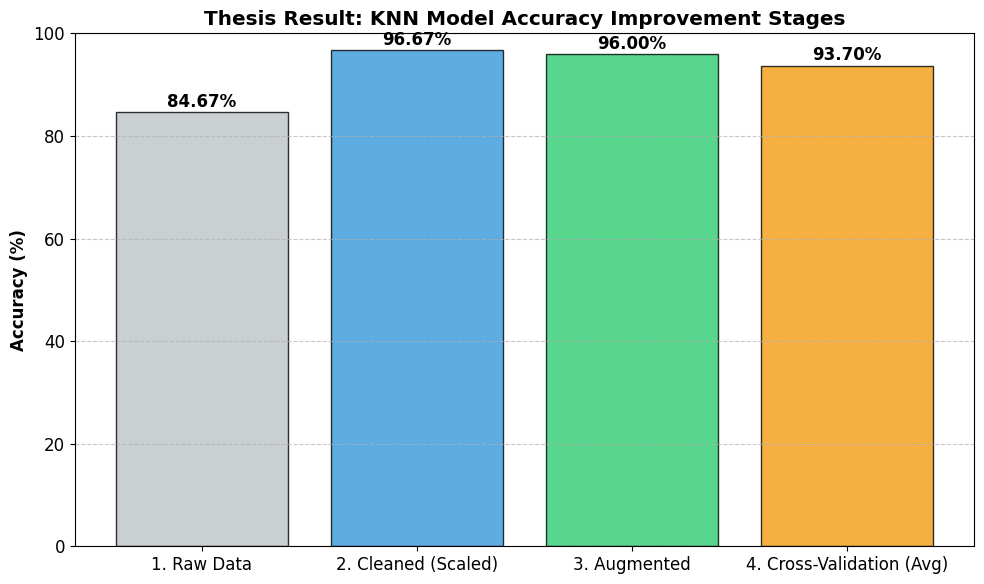

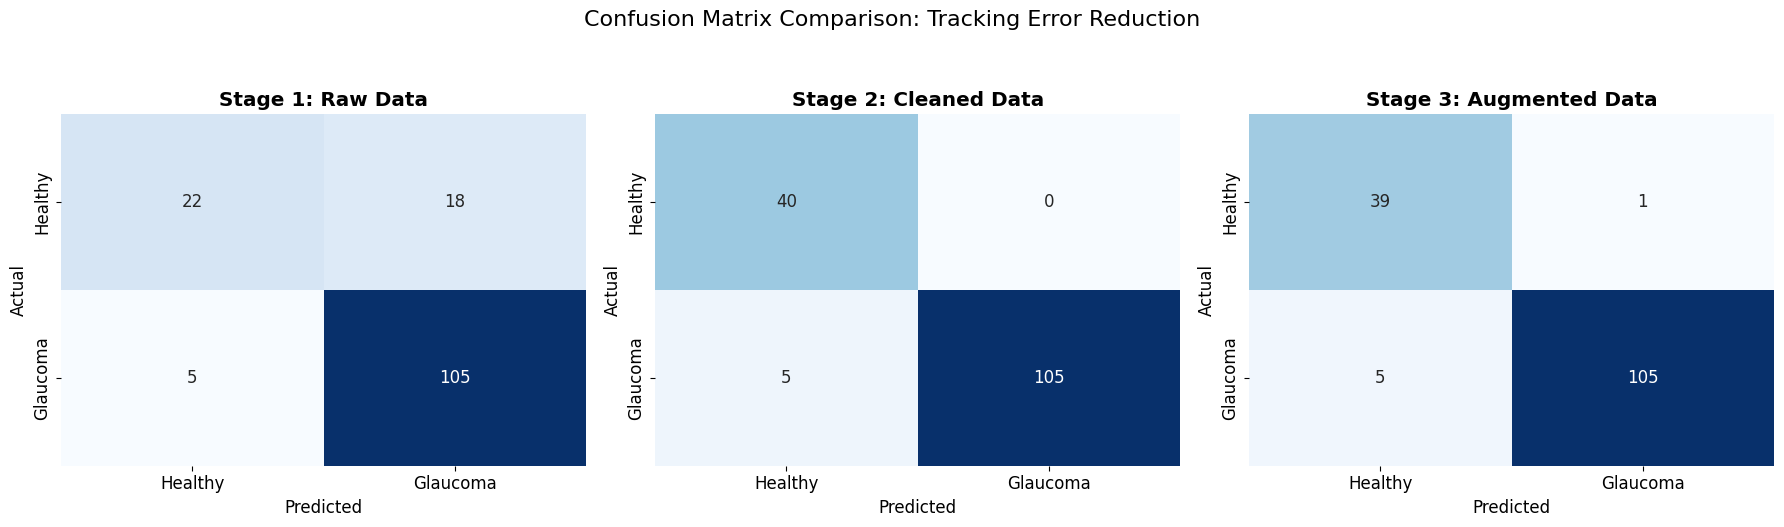

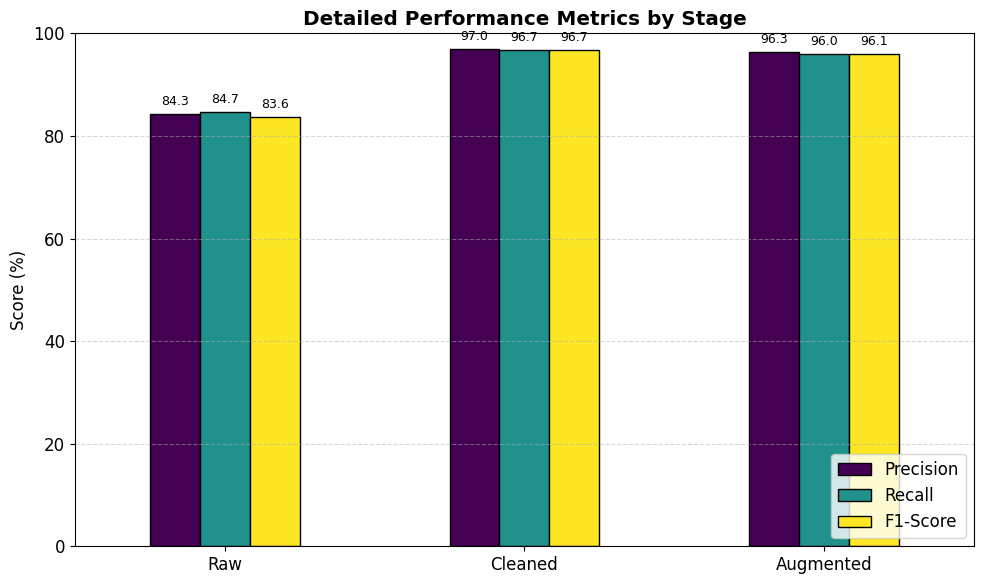


      FINAL RESULTS SUMMARY      
1. Raw Data               : 84.67%
2. Cleaned (Scaled)       : 96.67%
3. Augmented              : 96.00%
4. Cross-Validation (Avg) : 93.70%


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support

# Set up the figure size for all graphs
plt.rcParams.update({'font.size': 12})


# GRAPH 1: Overall Accuracy Comparison (Bar Chart)

plt.figure(figsize=(10, 6))
names = list(results.keys())
values = [v * 100 for v in results.values()]
colors = ['#bdc3c7', '#3498db', '#2ecc71', '#f39c12']

bars = plt.bar(names, values, color=colors, edgecolor='black', alpha=0.8)

plt.ylabel('Accuracy (%)', fontweight='bold')
plt.title('Result: KNN Model Accuracy Improvement Stages', fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text numbers on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.2f}%", ha='center', fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# GRAPH 2: Confusion Matrices Side-by-Side (Raw vs Clean vs Augmented)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# List of predictions and titles
model_preds = [
    (pred_raw, "Stage 1: Raw Data"),
    (pred_clean, "Stage 2: Cleaned Data"),
    (pred_aug, "Stage 3: Augmented Data")
]

for i, (preds, title) in enumerate(model_preds):
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False,
                xticklabels=['Healthy', 'Glaucoma'],
                yticklabels=['Healthy', 'Glaucoma'])
    axes[i].set_title(title, fontweight='bold')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.suptitle("Confusion Matrix Comparison: Tracking Error Reduction", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# GRAPH 3: Detailed Metrics Comparison (Precision, Recall, F1-Score)
metrics_data = []
stages = ["Raw", "Cleaned", "Augmented"]
prediction_sets = [pred_raw, pred_clean, pred_aug]

for pred in prediction_sets:
    # Get weighted average metrics
    p, r, f, _ = precision_recall_fscore_support(y_test, pred, average='weighted')
    metrics_data.append([p*100, r*100, f*100])

metrics_df = pd.DataFrame(metrics_data, columns=['Precision', 'Recall', 'F1-Score'], index=stages)

# Plot Grouped Bar Chart
metrics_df.plot(kind='bar', figsize=(10, 6), colormap='viridis', edgecolor='black')
plt.title('Detailed Performance Metrics by Stage', fontweight='bold')
plt.ylabel('Score (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.1f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

# FINAL SUMMARY TEXT
print("\n" + "="*40)
print("      FINAL RESULTS SUMMARY      ")
print("="*40)
for k, v in results.items():
    print(f"{k.ljust(25)} : {v*100:.2f}%")
print("="*40)

In [15]:
import os  
import joblib


model_path = os.path.join(DATASET_ROOT, 'knn_best_model.pkl')

joblib.dump(knn_aug, model_path)

print(f"KNN Model saved successfully at: {model_path}")

KNN Model saved successfully at: G:\Thesis-Fall-25-26--G-606\data\knn_best_model.pkl


Generating KNN Visualizations...


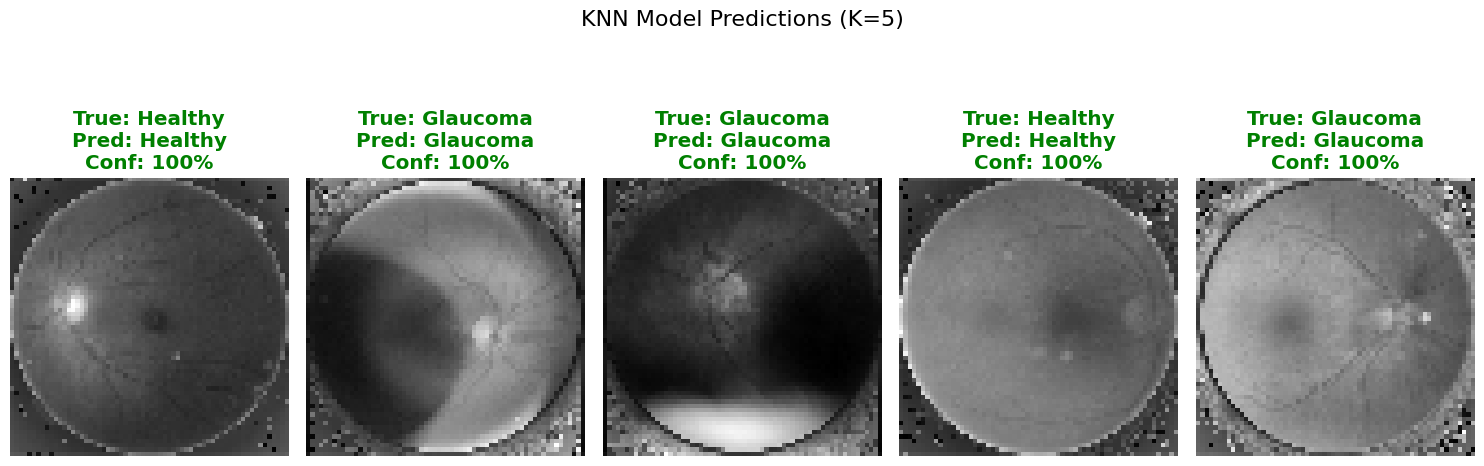

In [14]:
import random

# --- KNN PREDICTION VISUALIZATION ---
def visualize_knn_predictions(model, X_test, y_test, num_samples=5):
    plt.figure(figsize=(15, 6))
    
    
    indices = random.sample(range(len(X_test)), num_samples)
    
    for i, idx in enumerate(indices):
        img_flat = X_test[idx]
        true_label = y_test[idx]
        
        #  (Confidence)
        pred_label = model.predict([img_flat])[0]
        probs = model.predict_proba([img_flat])[0]
        confidence = max(probs) * 100
        
        
        img_reshaped = img_flat.reshape(64, 64)
        
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_reshaped, cmap='gray')
        

        color = 'green' if pred_label == true_label else 'red'
        label_map = {0: 'Healthy', 1: 'Glaucoma'}
        
        plt.title(f"True: {label_map[true_label]}\nPred: {label_map[pred_label]}\nConf: {confidence:.0f}%", 
                  color=color, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(f"KNN Model Predictions (K={model.n_neighbors})", fontsize=16)
    plt.tight_layout()
    plt.show()

print("Generating KNN Visualizations...")
try:
    visualize_knn_predictions(knn_cv.best_estimator_, X_test, y_test) 
except:
    visualize_knn_predictions(knn_aug, X_test_aug_clean, y_test)